In [54]:
import numpy as np
import pandas as pd
import torch
from rdkit import Chem
from sklearn import model_selection as sk_modelselection
from torch.nn import functional as F
from torch import nn
import matplotlib.pyplot as plt
import seaborn as sns
from torch.utils.data import DataLoader, Dataset
import functools
from graphmodels import constants, datasets, data_utils
from graphmodels import models as graphmodel_factory
from tqdm.notebook import tqdm
device = "cpu"
if torch.cuda.is_available():
    print("GPU is available")
    device = "cuda"
else:
    print("Running on CPU")

Running on CPU


# Load data

In [3]:
sol_df = pd.read_csv("../datasets/chemistry/delaney-processed.csv")
sol_df["mol"] = sol_df["smiles"].apply(Chem.MolFromSmiles)
sol_df["num_atoms"] = sol_df["mol"].apply(lambda x : x.GetNumAtoms())
MAX_NUM_ATOMS = sol_df["num_atoms"].max()
print(f"Max num atoms = {MAX_NUM_ATOMS}")

Max num atoms = 55


In [4]:
# Split data
train_df, test_df = sk_modelselection.train_test_split(sol_df, test_size=0.2, random_state=42, shuffle=True)
train_df, valid_df = sk_modelselection.train_test_split(train_df, test_size=0.15, random_state=42, shuffle=True)

In [5]:
train_df.shape, test_df.shape, valid_df.shape

((766, 12), (226, 12), (136, 12))

In [6]:
train_df

,Compound ID,ESOL predicted log solubility in mols per litre,Minimum Degree,Molecular Weight,Number of H-Bond Donors,Number of Rings,Number of Rotatable Bonds,Polar Surface Area,measured log solubility in mols per litre,smiles,mol,num_atoms
456,Etomidate,-3.359,1,244.294,0,2,4,44.12,-4.735,CCOC(=O)c1cncn1C(C)c2ccccc2,<rdkit.Chem.rdchem.Mol object at 0x7fa5e88eaab0>,18
938,isoguanine,-1.740,1,151.129,3,2,0,100.71,-3.401,Nc1nc(O)nc2nc[nH]c12,<rdkit.Chem.rdchem.Mol object at 0x7fa5e88f7f40>,11
925,RTI 6,-3.335,1,313.361,2,3,4,81.59,-3.360,CCN2c1nc(N(C)(CCO))ccc1NC(=O)c3cccnc23,<rdkit.Chem.rdchem.Mol object at 0x7fa5e88f7990>,23
810,Tetrahydropyran,-0.978,2,86.134,0,1,0,9.23,-0.030,C1CCOCC1,<rdkit.Chem.rdchem.Mol object at 0x7fa5e88f4740>,6
495,Minoxidil,-1.809,1,209.253,2,2,1,95.11,-1.989,Nc1cc(nc(N)n1=O)N2CCCCC2,<rdkit.Chem.rdchem.Mol object at 0x7fa5e88ebbc0>,15
...,...,...,...,...,...,...,...,...,...,...,...,...
837,Metoxuron,-2.683,1,228.679,1,1,2,41.57,-2.564,COc1ccc(NC(=O)N(C)C)cc1Cl,<rdkit.Chem.rdchem.Mol object at 0x7fa5e88f5310>,15
587,benodanil,-4.245,1,323.133,1,2,2,29.10,-4.210,c1c(NC(=O)c2ccccc2(I))cccc1,<rdkit.Chem.rdchem.Mol object at 0x7fa5e88ee490>,16
776,1-Methylcyclohexene,-2.574,1,96.173,0,1,0,0.00,-3.270,CC1=CCCCC1,<rdkit.Chem.rdchem.Mol object at 0x7fa5e88f37d0>,7
153,1-Chloropentane,-2.294,1,106.596,0,0,3,0.00,-2.730,CCCCCCl,<rdkit.Chem.rdchem.Mol object at 0x7fa5e88de500>,6


# Create datasets

In [7]:
train_dset = datasets.NeuralFingerprintDataset(smiles=tuple(train_df["smiles"]),
                                               targets=tuple(train_df["measured log solubility in mols per litre"]))

valid_dset = datasets.NeuralFingerprintDataset(smiles=tuple(valid_df["smiles"]),
                                               targets=tuple(valid_df["measured log solubility in mols per litre"]))

test_dset = datasets.NeuralFingerprintDataset(smiles=tuple(test_df["smiles"]),
                                               targets=tuple(test_df["measured log solubility in mols per litre"]))

In [8]:
train_dataloader = DataLoader(dataset=train_dset,
                              batch_size=32,
                              shuffle=True,
                              collate_fn=functools.partial(data_utils.neuralgraph_longest_collate,
                                                           max_num_atoms=MAX_NUM_ATOMS))

valid_dataloader = DataLoader(dataset=valid_dset,
                              batch_size=32,
                              shuffle=False,
                              collate_fn=functools.partial(data_utils.neuralgraph_longest_collate,
                                                           max_num_atoms=MAX_NUM_ATOMS))

test_dataloader = DataLoader(dataset=test_dset,
                              batch_size=32,
                              shuffle=False,
                              collate_fn=functools.partial(data_utils.neuralgraph_longest_collate,
                                                           max_num_atoms=MAX_NUM_ATOMS))

In [15]:
first_batch = next(iter(train_dataloader))

In [16]:
a,b,c,t = first_batch

In [17]:
t.shape

torch.Size([32])

# Train model

In [9]:
LEARNING_RATE: int = 1e-3
BATCH_SIZE: int = 64
N_EPOCHS: int = 5

In [45]:
model = graphmodel_factory.NeuralGraphFingerprintModel(num_input_features=(constants.NUM_ATOM_FEATURES*2+constants.NUM_BOND_FEATURES),
                                                       num_hidden_units=200,
                                                       num_output_units=1)
print(model)

NeuralGraphFingerprintModel(
  (lin_layer): Linear(in_features=296, out_features=200, bias=True)
  (out_layer): Linear(in_features=200, out_features=1, bias=True)
)


In [46]:
# Define loss function
loss_func = nn.MSELoss()

In [47]:
# Define optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)

In [48]:
def validate(model, val_loader, loss_fn, device):
    """
    Validate the model on the validation dataset.

    Args:
        model (torch.nn.Module): The neural network model.
        val_loader (DataLoader): DataLoader for validation data.
        loss_fn (callable): Loss function.
        device (torch.device): Device to run the validation on ('cpu' or 'cuda').

    Returns:
        float: Average validation loss.
    """
    model.eval()
    running_val_loss = 0.0

    with torch.no_grad():
        for atom_features, bond_features, adj_matrix, target in val_loader:
            atom_features = atom_features.to(device)
            bond_features = bond_features.to(device)
            adj_matrix = adj_matrix.to(device)
            target = target.to(device)
            
            pred = model((atom_features, bond_features, adj_matrix)).squeeze(-1)
            loss = loss_fn(pred, target)
            running_val_loss += loss.item()

    avg_val_loss = running_val_loss / len(val_loader)
    return avg_val_loss
    
def train(*, model, train_loader, val_loader, loss_fn, optimizer, device, epochs):
    """
    Train the model and validate after each epoch.

    Args:
        model (torch.nn.Module): The neural network model.
        train_loader (DataLoader): DataLoader for training data.
        val_loader (DataLoader): DataLoader for validation data.
        loss_fn (callable): Loss function.
        optimizer (torch.optim.Optimizer): Optimizer.
        device (torch.device): Device to run the training on ('cpu' or 'cuda').
        epochs (int): Number of training epochs.

    Returns:
        dict: Training and validation losses per epoch.
    """
    model.to(device)
    history = {'train_loss': [], 'val_loss': []}

    for epoch in range(epochs):
        model.train()
        running_train_loss = 0.0
        for batch, (atom_features, bond_features, adj_matrix, target) in tqdm(enumerate(train_loader, 0),
                                                                              total=epochs, leave=False):
            atom_features = atom_features.to(device)
            bond_features = bond_features.to(device)
            adj_matrix = adj_matrix.to(device)
            target = target.to(device)

            optimizer.zero_grad()
            pred = model((atom_features, bond_features, adj_matrix)).squeeze(-1)
            loss = loss_fn(pred, target)
            loss.backward()
            optimizer.step()

            running_train_loss += loss.item()

        avg_train_loss = running_train_loss / len(train_loader)
        history['train_loss'].append(avg_train_loss)

        avg_val_loss = validate(model, val_loader, loss_fn, device)
        history['val_loss'].append(avg_val_loss)

        print(f"Epoch {epoch+1}/{epochs} - "
              f"Train Loss: {avg_train_loss:.4f} - "
              f"Validation Loss: {avg_val_loss:.4f}")

    return history

In [49]:
history = train(model=model,
      train_loader=train_dataloader,
      val_loader=valid_dataloader,
      loss_fn=loss_func,
      optimizer=optimizer,
      device="cpu",
      epochs=30)

  0%|          | 0/30 [00:00<?, ?it/s]

Epoch 1/30 - Train Loss: 3.7435 - Validation Loss: 1.7383


  0%|          | 0/30 [00:00<?, ?it/s]

Epoch 2/30 - Train Loss: 1.5948 - Validation Loss: 1.2982


  0%|          | 0/30 [00:00<?, ?it/s]

Epoch 3/30 - Train Loss: 1.2880 - Validation Loss: 1.0524


  0%|          | 0/30 [00:00<?, ?it/s]

Epoch 4/30 - Train Loss: 1.1498 - Validation Loss: 0.9860


  0%|          | 0/30 [00:00<?, ?it/s]

Epoch 5/30 - Train Loss: 1.0845 - Validation Loss: 0.9326


  0%|          | 0/30 [00:00<?, ?it/s]

Epoch 6/30 - Train Loss: 1.0566 - Validation Loss: 0.8135


  0%|          | 0/30 [00:00<?, ?it/s]

Epoch 7/30 - Train Loss: 1.0122 - Validation Loss: 0.8175


  0%|          | 0/30 [00:00<?, ?it/s]

Epoch 8/30 - Train Loss: 0.9785 - Validation Loss: 0.8181


  0%|          | 0/30 [00:00<?, ?it/s]

Epoch 9/30 - Train Loss: 0.9377 - Validation Loss: 0.8124


  0%|          | 0/30 [00:00<?, ?it/s]

Epoch 10/30 - Train Loss: 0.9380 - Validation Loss: 0.8000


  0%|          | 0/30 [00:00<?, ?it/s]

Epoch 11/30 - Train Loss: 0.9897 - Validation Loss: 0.7639


  0%|          | 0/30 [00:00<?, ?it/s]

Epoch 12/30 - Train Loss: 0.9107 - Validation Loss: 0.8573


  0%|          | 0/30 [00:00<?, ?it/s]

Epoch 13/30 - Train Loss: 0.8913 - Validation Loss: 0.8082


  0%|          | 0/30 [00:00<?, ?it/s]

Epoch 14/30 - Train Loss: 0.8816 - Validation Loss: 0.7989


  0%|          | 0/30 [00:00<?, ?it/s]

Epoch 15/30 - Train Loss: 0.9193 - Validation Loss: 0.7745


  0%|          | 0/30 [00:00<?, ?it/s]

Epoch 16/30 - Train Loss: 0.9030 - Validation Loss: 0.7416


  0%|          | 0/30 [00:00<?, ?it/s]

Epoch 17/30 - Train Loss: 0.8545 - Validation Loss: 0.7431


  0%|          | 0/30 [00:00<?, ?it/s]

Epoch 18/30 - Train Loss: 0.8886 - Validation Loss: 0.8102


  0%|          | 0/30 [00:00<?, ?it/s]

Epoch 19/30 - Train Loss: 0.8613 - Validation Loss: 0.7044


  0%|          | 0/30 [00:00<?, ?it/s]

Epoch 20/30 - Train Loss: 0.8414 - Validation Loss: 0.7191


  0%|          | 0/30 [00:00<?, ?it/s]

Epoch 21/30 - Train Loss: 0.9564 - Validation Loss: 0.7256


  0%|          | 0/30 [00:00<?, ?it/s]

Epoch 22/30 - Train Loss: 0.9219 - Validation Loss: 0.8731


  0%|          | 0/30 [00:00<?, ?it/s]

Epoch 23/30 - Train Loss: 0.8571 - Validation Loss: 0.7198


  0%|          | 0/30 [00:00<?, ?it/s]

Epoch 24/30 - Train Loss: 0.8738 - Validation Loss: 0.7008


  0%|          | 0/30 [00:00<?, ?it/s]

Epoch 25/30 - Train Loss: 0.8834 - Validation Loss: 0.7655


  0%|          | 0/30 [00:00<?, ?it/s]

Epoch 26/30 - Train Loss: 0.8811 - Validation Loss: 1.1493


  0%|          | 0/30 [00:00<?, ?it/s]

Epoch 27/30 - Train Loss: 0.8764 - Validation Loss: 0.7266


  0%|          | 0/30 [00:00<?, ?it/s]

Epoch 28/30 - Train Loss: 0.8968 - Validation Loss: 0.7008


  0%|          | 0/30 [00:00<?, ?it/s]

Epoch 29/30 - Train Loss: 0.8229 - Validation Loss: 0.6996


  0%|          | 0/30 [00:00<?, ?it/s]

Epoch 30/30 - Train Loss: 0.8413 - Validation Loss: 0.7306


In [56]:
history.keys()

dict_keys(['train_loss', 'val_loss'])

In [53]:
epochs = list(range(30))

Text(0.5, 0, 'Loss')

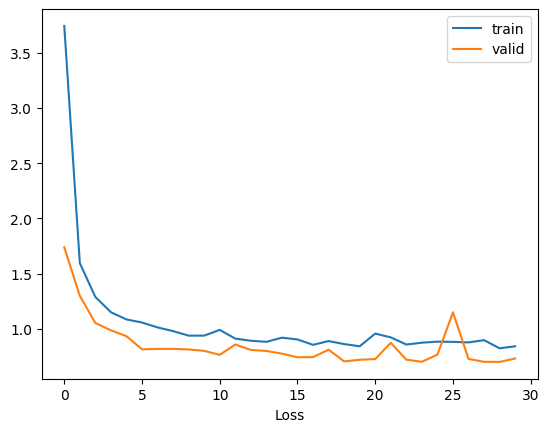

In [62]:
ax = sns.lineplot(x=epochs, y=history["train_loss"], label="train")
ax = sns.lineplot(x=epochs, y=history["val_loss"], label="valid")

ax.set_xlabel("Epoches")
ax.set_xlabel("Loss")